In [1]:
import torch
import torchaudio
from torchaudio.pipelines import TACOTRON2_WAVERNN_PHONE_LJSPEECH
import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

import time


2.3.0+cu121
2.3.0+cu121
cuda


In [2]:
text = '''The paper, titled "The Born in Guangzhou Cohort Study enables generational genetic discoveries" and compiled by experts from the Guangzhou Women and Children's Medical Center, was published in the academic journal Nature on Wednesday. It reveals how, using scientific methods, health issues concerning parents, especially mothers, and children can be more efficiently addressed.'''


In [3]:
start = time.time()
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    #print(processed,lengths)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    #waveforms, lengths = vocoder(spec, spec_lengths)
    
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

print('总耗时:{}s'.format(round(time.time()-start,3)))

def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


#plot(waveforms, spec, vocoder.sample_rate)

RuntimeError: DeepPhonemizer is not installed. Please install it.

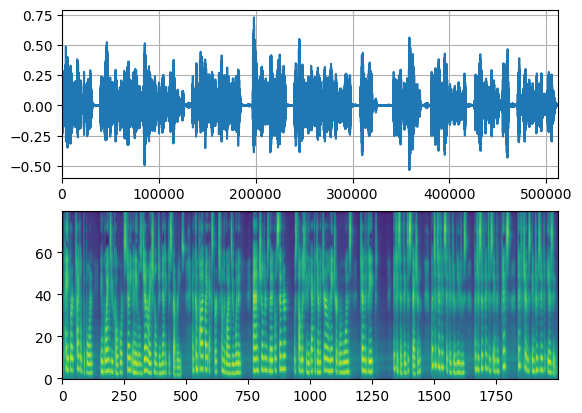

In [13]:
plot(waveforms, spec, 22050)